In [1]:
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os,sys
import numpy as np
import pandas as pd

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), '../..', 'src')
sys.path.append(src_dir)

%aimport plot_utils
from plot_utils import *
%aimport preprocessing
from preprocessing import *
%aimport data_source
from data_source import *
%aimport model_manage
from model_manage import *
%aimport algorithm
from algorithm import *

import logging
from utils import *
set_logger(logging.DEBUG)

In [2]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

In [3]:
ds = DataSource(host='localhost',port=5432, username='postgres', password='', database='sdra')
ds.show_views()

[dp] connect to database postgresql://postgres:@localhost:5432/sdra
[dp] supported views: ['properties', 'property_features', 'transactions', 'property_addresses', 'property_address_transactions', 'property_transaction_valid', 'property_address_school_transactions', 'property_address_schools']


In [6]:
df_transaction = ds.get_view_df('property_address_school_transactions')
df_property = ds.get_view_df('property_address_schools')
print(df_transaction.shape)
print(df_property.shape)

(1477830, 37)
(710576, 34)


In [7]:
pp = Preprocess(df_transaction, df_property)
use_features = pp.get_feature_list()
school_features = ['min_elem_distance', 'min_middle_distance', 'min_high_distance',
                   'elem_rating', 'middle_rating', 'high_rating',
                   'avg_elem_rating', 'avg_high_rating', 'avg_middle_rating']
use_features = list(set(use_features ) - set(school_features))

df_all = pp.dataset(feature='all', valid=True)

[dp] transforming date
[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming min_elem_distance
[dp] transforming min_middle_distance
[dp] transforming min_high_distance
[dp] transforming elem_rating
[dp] transforming middle_rating
[dp] transforming high_rating
[dp] transforming avg_elem_rating
[dp] transforming avg_middle_rating
[dp] transforming avg_high_rating
[dp] transforming sold_year
[dp] transforming sold_month
[dp] transforming sold_age
[dp] transforming eval
[dp] transforming eval_sqft_price
[dp] making sqft_zip_avg
[dp] making sqft_over_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making eval_zip_avg
[dp] making eval_over_zip_avg
[dp] making sale_count_zip
[dp] cleaning on criteria: sold_price
[dp] cleaning on criteria: sqft_price
[dp] cleaning on criteria: sqft
[dp] cleaning on criteria: num_bed
[dp] cleaning on criteria: num_bath
[dp] cleaning on criteria: lon


## transaction 


In [8]:
zip_counts = df_all['zip'].value_counts()

sqft_price_series = df_all.groupby(by=['zip','sold_year'])['sqft_price'].median().unstack(level=-1)
trans_count_series = df_all.groupby(by=['zip','sold_year'])['sqft_price'].count().unstack(level=-1)

In [9]:
std_sample = df_all.groupby(by=['zip','sold_year'])['sqft_price'].std().unstack(level=-1)
std_series = std_sample / trans_count_series.pow(1./2)

In [68]:
T_trans_count = 40
T_null = 8
sqft_price_series_filter = sqft_price_series[trans_count_series > T_trans_count]
#sqft_price_series_filter.isnull().sum(axis=1).value_counts()
sqft_price_series_valid = sqft_price_series_filter[sqft_price_series_filter.isnull().sum(axis=1) < T_null]
sqft_price_series_invalid = sqft_price_series_filter[sqft_price_series_filter.isnull().sum(axis=1) >= T_null]
print('valid shape', sqft_price_series_valid.shape)
print(sqft_price_series_valid.isnull().sum(axis=1).value_counts())
print('invalid shape', sqft_price_series_invalid.shape)
sqft_price_series_invalid.isnull().sum(axis=1).value_counts()

trans_count_series_valid = trans_count_series[sqft_price_series_filter.isnull().sum(axis=1) < T_null]
trans_count_series_fill = trans_count_series_valid.copy().fillna(0)

valid shape (80, 35)
0    75
2     2
4     1
3     1
1     1
dtype: int64
invalid shape (20, 35)


In [ ]:
### fill nan with EM svd
Y_hat, mu_hat, U, s, Vt = emsvd(sqft_price_series_valid)
sqft_price_series_em = pd.DataFrame(Y_hat, index=sqft_price_series_valid.index, columns=sqft_price_series_valid.columns)

In [40]:
sqft_price_series_em = sqft_price_series_valid.interpolate(method='akima', axis=1)
sqft_price_series_em = sqft_price_series_em.fillna(sqft_price_series_em.median())

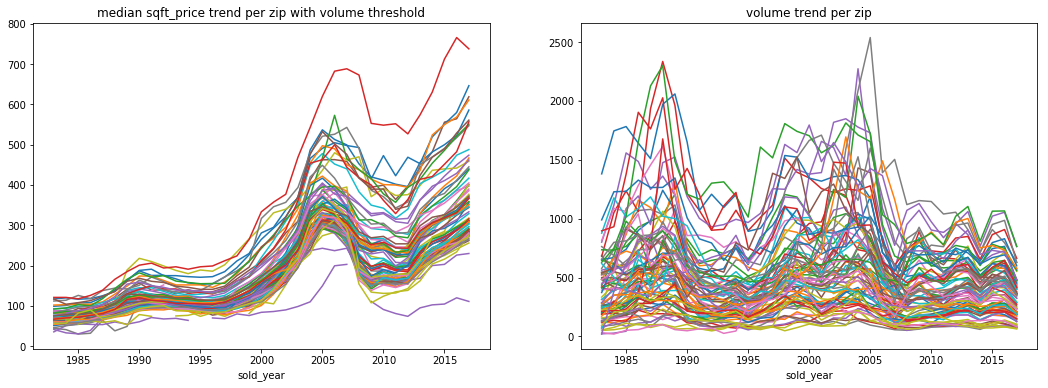

In [12]:
fig, ax = plt.subplots(1,2, figsize=(18,6))
#top_zips = zip_counts.index[0:30]
top_zips = zip_counts.index
top_zips = sqft_price_series_valid.index

for zip in top_zips:
    ax[0].set_title("median sqft_price trend per zip with volume threshold")
    sqft_price_series_valid.loc[zip].plot(ax=ax[0], kind='line', label=zip)
    ax[1].set_title("volume trend per zip")
    trans_count_series_valid.loc[zip].plot(ax=ax[1], kind='line', label=zip)
#plt.legend(loc='best')
plt.show()

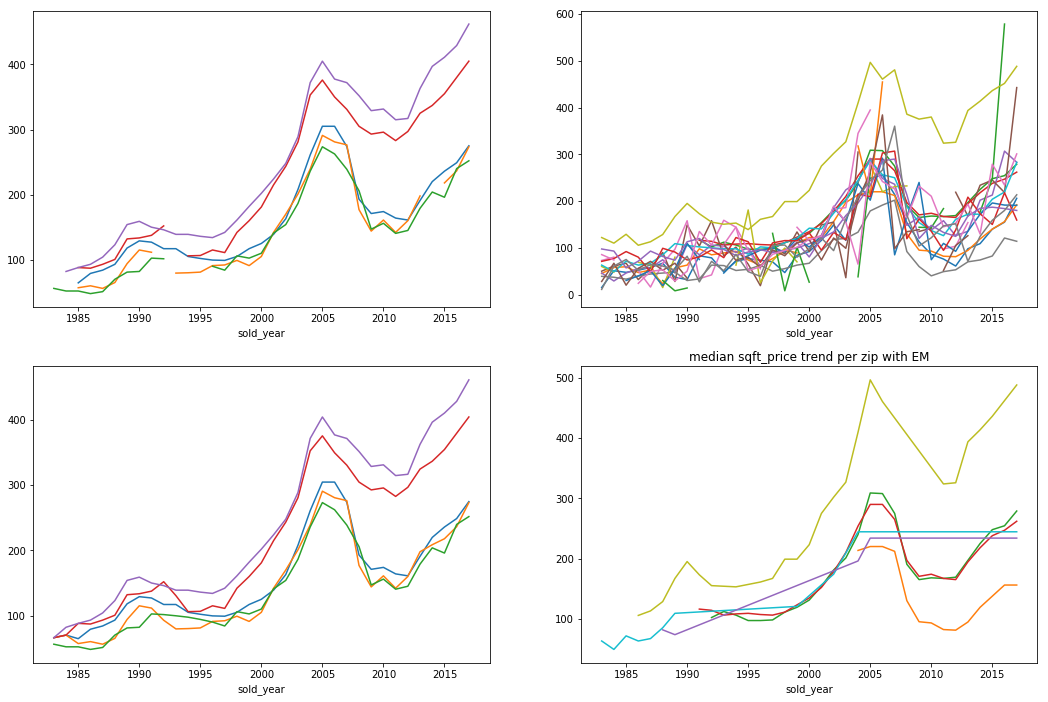

In [41]:
fig, ax = plt.subplots(2, 2, figsize=(18,12))
for zip in sqft_price_series_valid.index:
    if sqft_price_series_valid.loc[zip].isnull().sum() == 0: continue
    sqft_price_series_valid.loc[zip].plot(ax=ax[0,0], kind='line', label=zip)
    sqft_price_series_em.loc[zip].plot(ax=ax[1,0], kind='line', label=zip)
for zip in sqft_price_series_invalid.index:
    sqft_price_series.loc[zip].plot(ax=ax[0,1], kind='line', label=zip)
    #sqft_price_series_invalid.loc[zip].plot(ax=ax[1,1], kind='line', label=zip)
    sqft_price_series_invalid.interpolate(axis=1).loc[zip].plot(ax=ax[1,1], kind='line', label=zip)
#plt.legend(loc='best')
plt.title("median sqft_price trend per zip with EM")
plt.show()

### clustering on zip based on their trending series

In [42]:
def get_series(df_complete):
    series_next = df_complete[df_complete.columns[1:]]
    series_prev = df_complete[df_complete.columns[:-1]].copy()
    series_prev.columns = series_next.columns
    series_diff = series_next - series_prev
    series_yoy = series_diff / series_prev
    return series_diff, series_yoy

In [43]:
sqft_price_series_diff,sqft_price_series_yoy = get_series(sqft_price_series_em)

In [44]:
import seaborn as sns
import sklearn.covariance as covariance

zips_valid = sqft_price_series_valid.index
# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery
X = sqft_price_series_em.copy().T
X /= X.std(axis=0)
corr = X.corr()
edge_model = covariance.GraphLassoCV()
edge_model.fit(X)
corr_gl = edge_model.covariance_

X = sqft_price_series_diff.copy().T
X /= X.std(axis=0)
corr_diff = X.corr()
edge_model_diff = covariance.GraphLassoCV()
edge_model_diff.fit(X)
corr_gl_diff = edge_model_diff.covariance_

X = sqft_price_series_yoy.copy().T
X /= X.std(axis=0)
corr_yoy = X.corr()
edge_model_yoy = covariance.GraphLassoCV()
edge_model_yoy.fit(X)
corr_gl_yoy = edge_model_yoy.covariance_

C:\Users\wenyan\Anaconda3\envs\cap\lib\site-packages\numpy\linalg\linalg.py:1817: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
C:\Users\wenyan\Anaconda3\envs\cap\lib\site-packages\numpy\linalg\linalg.py:1817: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
C:\Users\wenyan\Anaconda3\envs\cap\lib\site-packages\numpy\linalg\linalg.py:1817: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
C:\Users\wenyan\Anaconda3\envs\cap\lib\site-packages\sklearn\covariance\graph_lasso_.py:230: RuntimeWarning: invalid value encountered in multiply
  * coefs)
C:\Users\wenyan\Anaconda3\envs\cap\lib\site-packages\sklearn\covariance\graph_lasso_.py:232: RuntimeWarning: invalid value encountered in multiply
  * coefs)
C:\Users\wenyan\Anaconda3\envs\cap\lib\site-packages\numpy\linalg\linalg.py:1817: RuntimeW

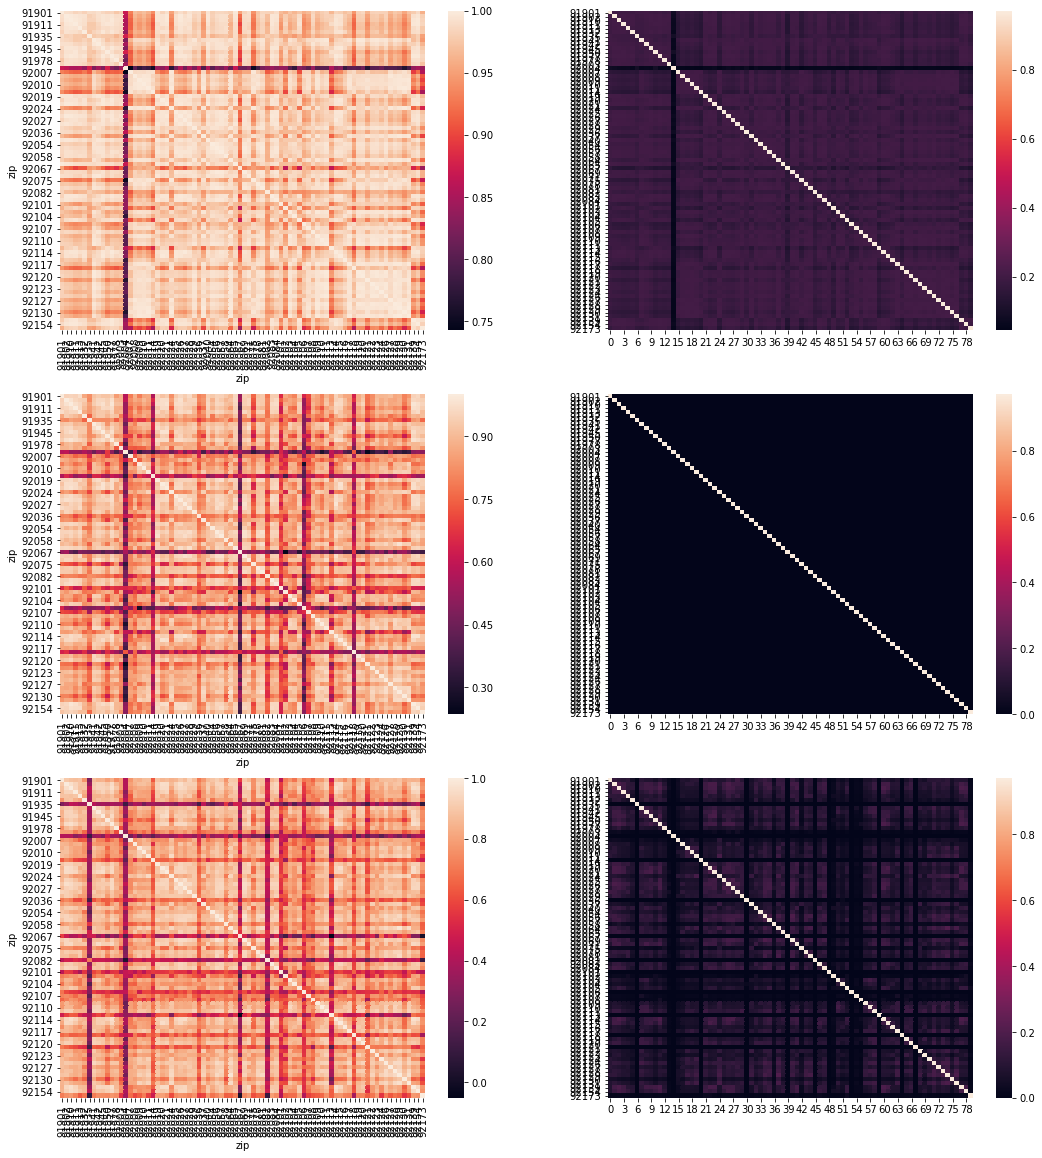

In [46]:
#plt.figure(figsize=(13,10))
fig, ax = plt.subplots(3, 2, figsize=(18,20))
sns.heatmap(corr, ax=ax[0,0], xticklabels=zips_valid)
sns.heatmap(corr_gl, ax=ax[0,1],yticklabels=zips_valid)
sns.heatmap(corr_diff, ax=ax[1,0], xticklabels=zips_valid)
sns.heatmap(corr_gl_diff, ax=ax[1,1], yticklabels=zips_valid)
sns.heatmap(corr_yoy, ax=ax[2,0], xticklabels=zips_valid)
sns.heatmap(corr_gl_yoy, ax=ax[2,1], yticklabels=zips_valid)

In [47]:
def plot_trend_cluster(df_zip_series, labels, ax=None, title=None, verbose=False):
    rgb_values = sns.color_palette("Set1", labels.max()+1)
    if labels.max() <= 6:
        rgb_values = ['red','green','orange','blue','yellow', 'purple', 'black']
    
    if not ax:
        fig, ax = plt.subplots(figsize=(9,6))
    
    for idx,zip in enumerate(df_zip_series.index):
        color = rgb_values[labels[idx]]
        df_zip_series.loc[zip].plot(ax=ax, kind='line', label=zip, c=color)

    if df_zip_series.shape[0] < 10:
        plt.legend(loc='best')
    
    if not title: title = "median sqft_price trend per zip with clustering"
    ax.set_title(title)    
    
    if verbose:
        for i in range(labels.max()+1):
            color = rgb_values[i]
            print('Cluster %i (%s): %s' % (i, color, ', '.join(zips_valid[labels == i])))

In [48]:
from sklearn import cluster
from sklearn import mixture

def cluster_trend(df_series, feature=''):
    labels = {}
    # Cluster using affinity propagation
    _, labels['affinity'] = cluster.affinity_propagation(df_series)

    # spectral clustering
    spectral = cluster.SpectralClustering(n_clusters=5, eigen_solver='arpack', affinity="nearest_neighbors")
    spectral.fit(df_series)
    labels['spectral'] = spectral.labels_

    # GMM
    gmm = mixture.GaussianMixture(n_components=5, covariance_type='full')
    gmm.fit(df_series)
    labels['gmm'] = gmm.predict(df_series)

    fig, ax = plt.subplots(2, 2, figsize=(18,12))

    plot_trend_cluster(sqft_price_series_em, labels['affinity'], ax[0,0], feature +' trend per zip with affinity propagation')
    plot_trend_cluster(sqft_price_series_em, labels['spectral'], ax[0,1], feature + ' trend per zip with spectral clustering')
    plot_trend_cluster(sqft_price_series_em, labels['gmm'], ax[1,0], feature + ' trend per zip with GMM')
    plt.show()
    
    return labels

C:\Users\wenyan\Anaconda3\envs\cap\lib\site-packages\sklearn\cluster\spectral.py:442: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


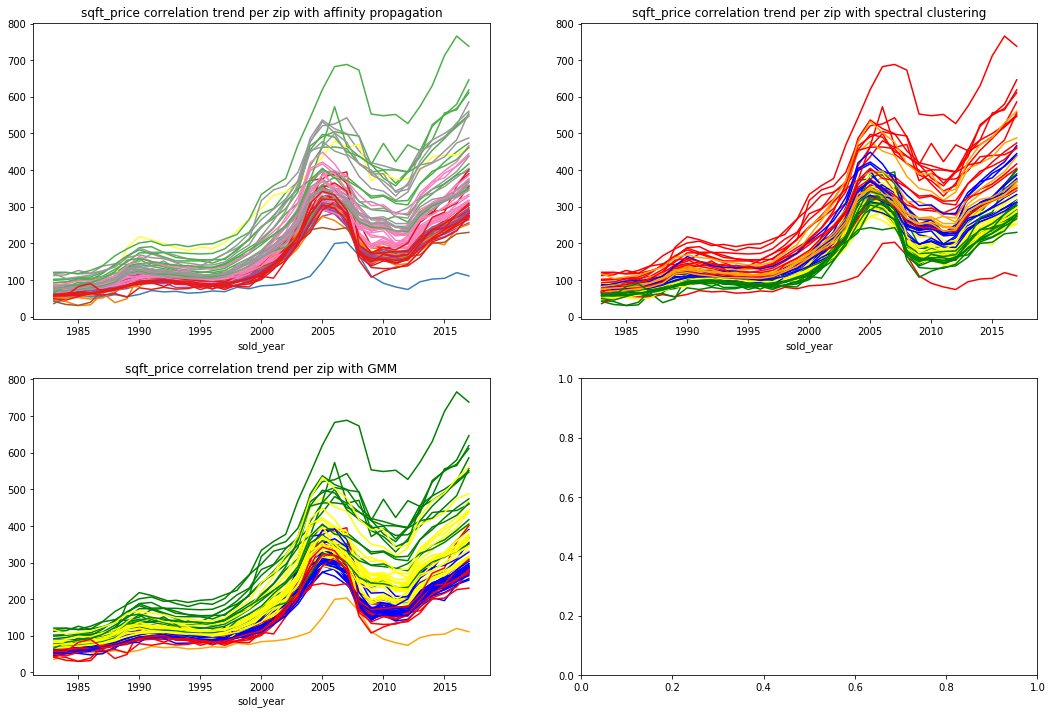

In [50]:
labels = cluster_trend(corr, 'sqft_price correlation')

In [51]:
### print zipo clusters
for i in range(labels['gmm'].max() + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(zips_valid[labels['gmm'] == i])))

Cluster 1: 91911, 91935, 91950, 91978, 92082, 92102, 92105, 92113, 92139, 92173
Cluster 2: 92007, 92009, 92011, 92014, 92024, 92037, 92067, 92075, 92101, 92106, 92107, 92118, 92121, 92127, 92130
Cluster 3: 92004
Cluster 4: 91901, 91902, 91910, 91913, 91932, 91942, 91945, 91977, 92003, 92019, 92020, 92021, 92025, 92026, 92027, 92028, 92036, 92040, 92057, 92058, 92065, 92069, 92083, 92084, 92108, 92114, 92115, 92154
Cluster 5: 91941, 92008, 92010, 92029, 92054, 92056, 92064, 92071, 92078, 92081, 92103, 92104, 92109, 92110, 92111, 92116, 92117, 92119, 92120, 92122, 92123, 92124, 92126, 92128, 92129, 92131


C:\Users\wenyan\Anaconda3\envs\cap\lib\site-packages\sklearn\cluster\spectral.py:442: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


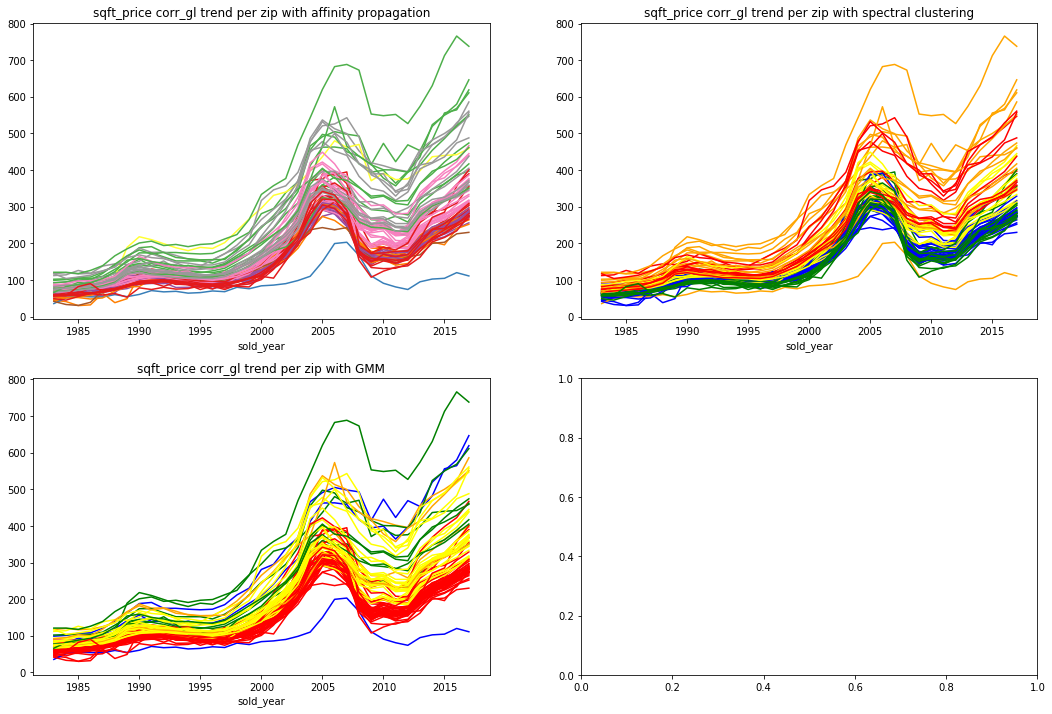

In [52]:
labels = cluster_trend(corr_gl, 'sqft_price corr_gl')

Cluster 0 (red): 91901, 91902, 91910, 91911, 91913, 91935, 91945, 91950, 91977, 91978, 92003, 92019, 92020, 92021, 92025, 92026, 92027, 92028, 92029, 92040, 92056, 92057, 92058, 92065, 92069, 92071, 92078, 92081, 92083, 92084, 92105, 92114, 92139, 92154, 92173
Cluster 1 (green): 92007, 92014, 92037, 92067, 92075, 92101, 92103, 92106, 92107, 92109
Cluster 2 (orange): 92118
Cluster 3 (blue): 92008, 92011, 92024, 92104, 92116, 92117, 92121, 92122, 92130
Cluster 4 (yellow): 91932, 91941, 91942, 92009, 92010, 92054, 92064, 92102, 92108, 92110, 92111, 92115, 92119, 92120, 92123, 92124, 92126, 92127, 92128, 92129, 92131
Cluster 5 (purple): 92004, 92036, 92082, 92113


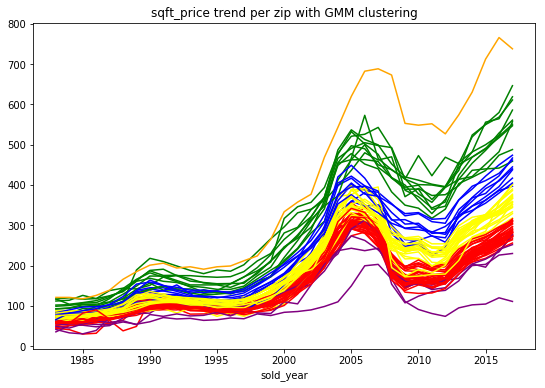

In [53]:
gmm = mixture.GaussianMixture(n_components=6, covariance_type='full')
gmm.fit(sqft_price_series_em)
cluster_price = gmm.predict(sqft_price_series_em)
plot_trend_cluster(sqft_price_series_em, cluster_price, None, 'sqft_price trend per zip with GMM clustering', True)

### volume trending

In [56]:
trans_count_series_valid.shape

(82, 35)

Cluster 0 (red): 91910, 91911, 91913, 91977, 92019, 92024, 92026, 92027, 92028, 92037, 92064, 92071, 92078, 92101, 92114, 92115, 92117, 92127, 92131, 92154
Cluster 1 (green): 91901, 91902, 91932, 91935, 91945, 91950, 91978, 92003, 92004, 92007, 92014, 92029, 92036, 92058, 92067, 92075, 92082, 92102, 92104, 92106, 92107, 92113, 92116, 92118, 92121, 92123, 92173
Cluster 2 (orange): 92056, 92057, 92126, 92128, 92129
Cluster 3 (blue): 91941, 91942, 92008, 92010, 92011, 92020, 92021, 92025, 92040, 92054, 92065, 92069, 92081, 92083, 92084, 92103, 92105, 92108, 92109, 92110, 92111, 92119, 92120, 92122, 92124, 92139
Cluster 4 (yellow): 92009, 92130


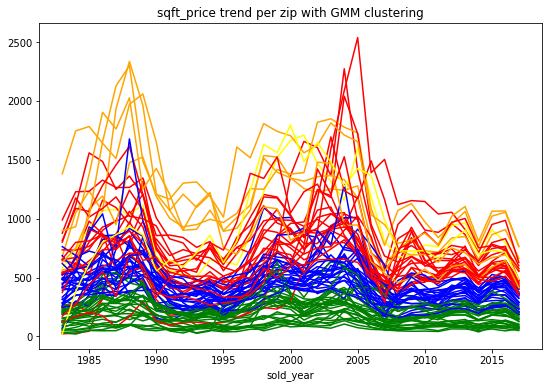

In [69]:
gmm = mixture.GaussianMixture(n_components=5, covariance_type='full')
gmm.fit(trans_count_series_fill)
cluster_volume = gmm.predict(trans_count_series_fill)
plot_trend_cluster(trans_count_series_valid, cluster_volume, None, 'sqft_price trend per zip with GMM clustering', True)

### seasonal factor

In [70]:
df_all_month = df_all.copy()
df_all_month['sold_month'] = df_all_month['date'].dt.month
# trans_count_series = df_all.groupby(by=['zip','sold_year'])['sqft_price'].count().unstack(level=-1)
monthly_volume = df_all_month.groupby(by=['sold_year', 'sold_month'])['sqft_price'].count().unstack(level=-1)
monthly_price = df_all_month.groupby(by=['sold_year', 'sold_month'])['sqft_price'].median().unstack(level=-1)

In [92]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
monthly_price_norm = min_max_scaler.fit_transform(monthly_price.dropna(axis=0).T).T
#monthly_price_norm = monthly_price.div(monthly_price.median(axis=1), axis=0)

Text(0.5,1,'heatmap of median price in year vs month')

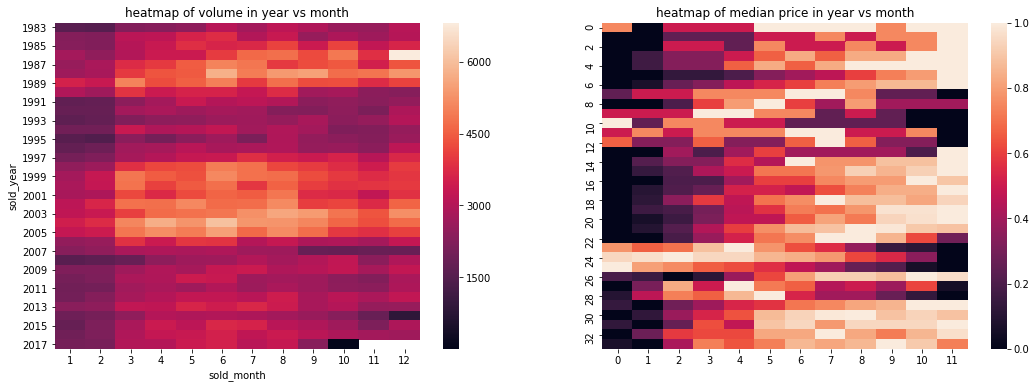

In [93]:
fig,ax = plt.subplots(1, 2, figsize=(18, 6))
sns.heatmap(monthly_volume, ax=ax[0])
ax[0].set_title('heatmap of volume in year vs month')
sns.heatmap(monthly_price_norm, ax=ax[1])
ax[1].set_title('heatmap of median price in year vs month')

In [95]:
zip_cluster = pd.DataFrame({'zip': zips_valid, 'cluster': cluster_price})

In [108]:
df_all_cluster = df_all_month.merge(zip_cluster, on='zip')
monthly_volume = df_all_cluster.groupby(by=['cluster', 'sold_year', 'sold_month'])['sqft_price'].count().unstack(level=-1)
monthly_price = df_all_cluster.groupby(by=['cluster', 'sold_year', 'sold_month'])['sqft_price'].median().unstack(level=-1)

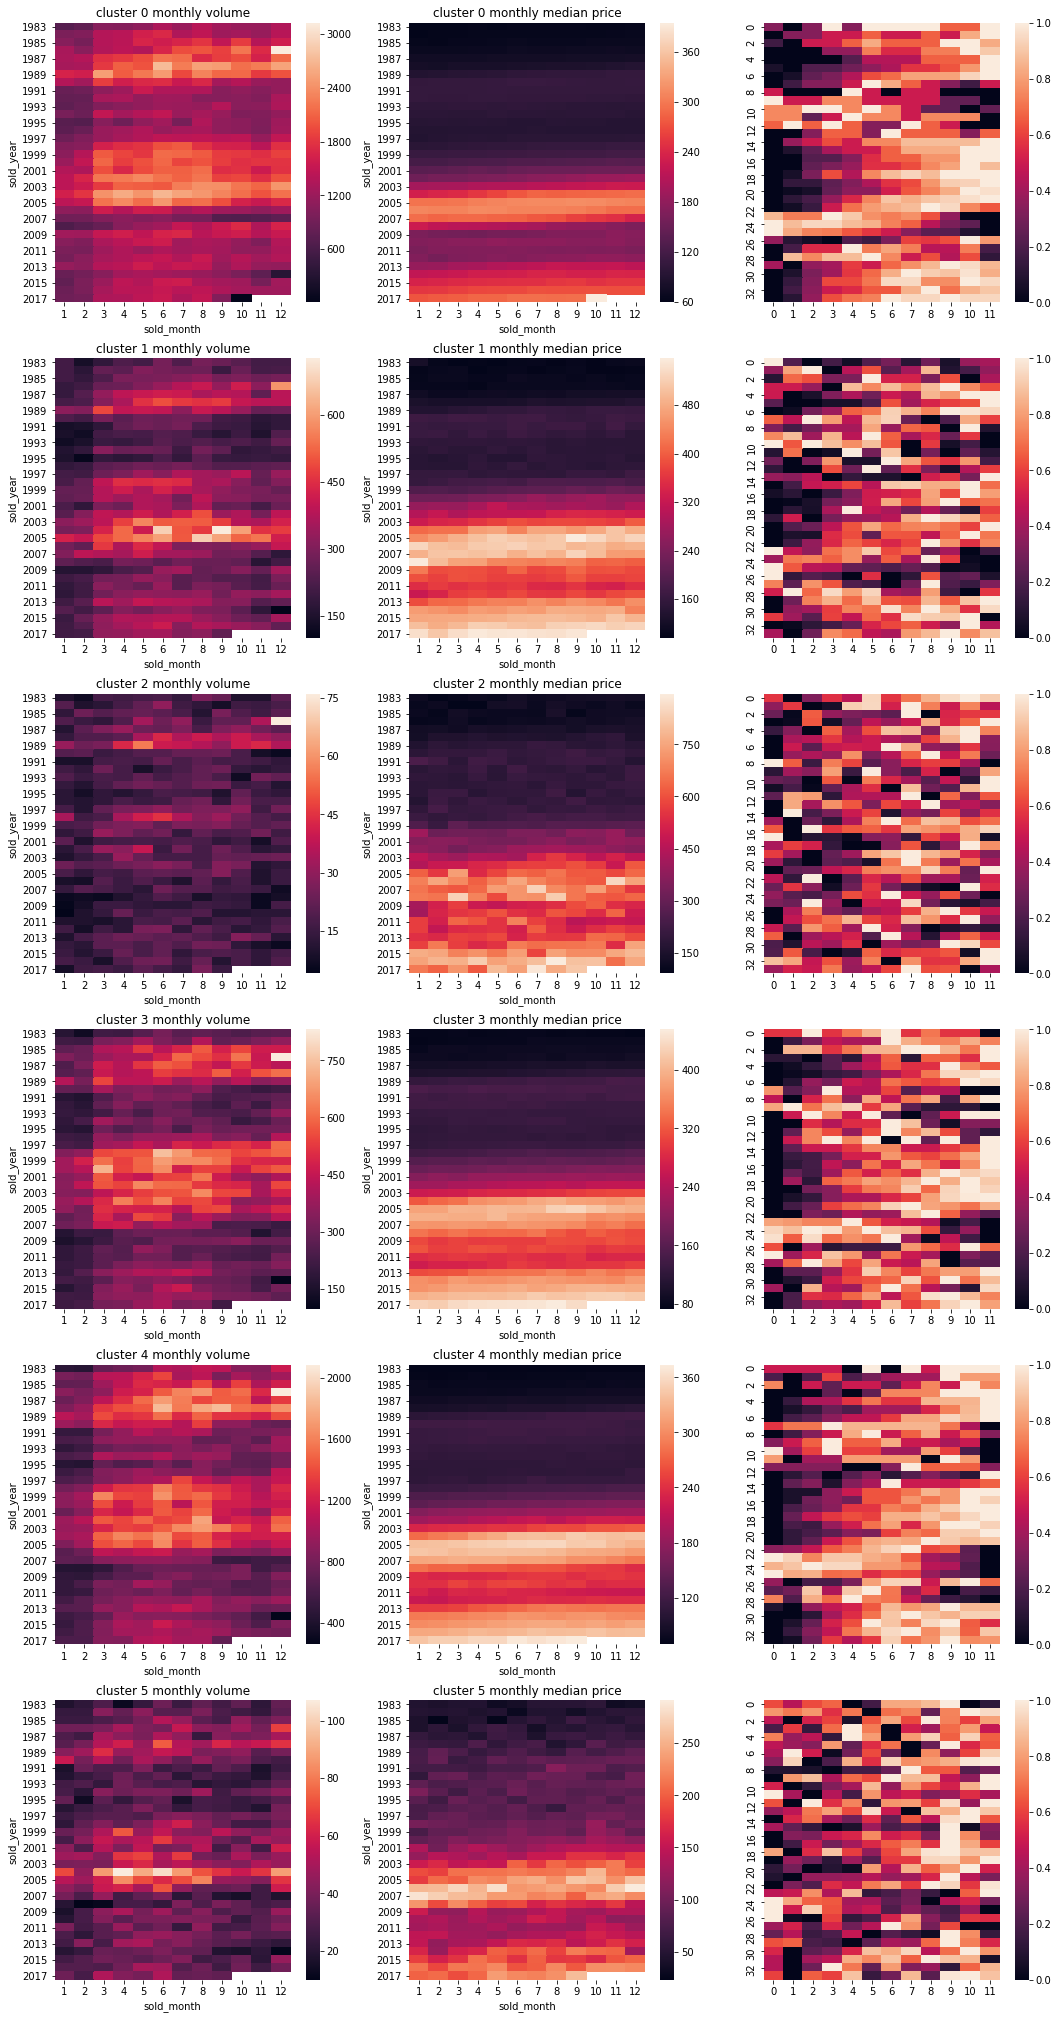

In [112]:
n_cluster = cluster_price.max()+1
fig,ax = plt.subplots(n_cluster, 3, figsize=(18, n_cluster*6))
#plt.subplots_adjust(hspace=1)
for i in range(n_cluster):
    sns.heatmap(monthly_volume.loc[i], ax=ax[i,0])
    ax[i,0].set_title('cluster {} monthly volume'.format(i))
    sns.heatmap(monthly_price.loc[i], ax=ax[i,1])
    ax[i,1].set_title('cluster {} monthly median price'.format(i))
    monthly_price_norm = min_max_scaler.fit_transform(monthly_price.loc[i].dropna(axis=0).T).T
    sns.heatmap(monthly_price_norm, ax=ax[i,2])
plt.show()

In [105]:
df_1year = df_all_month[(df_all_month['date'] >= '2015-01-01')&
                              (df_all_month['date'] < '2016-01-01')
                             ].merge(zip_cluster, on='zip')
monthly_volume = df_1year.groupby(by=['cluster', 'sold_month'])['sqft_price'].count().unstack(level=-1)
monthly_price = df_1year.groupby(by=['cluster', 'sold_month'])['sqft_price'].median().unstack(level=-1)

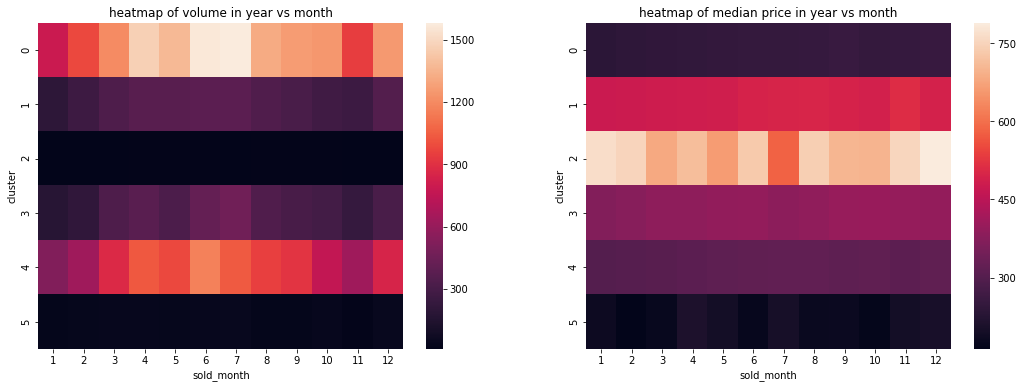

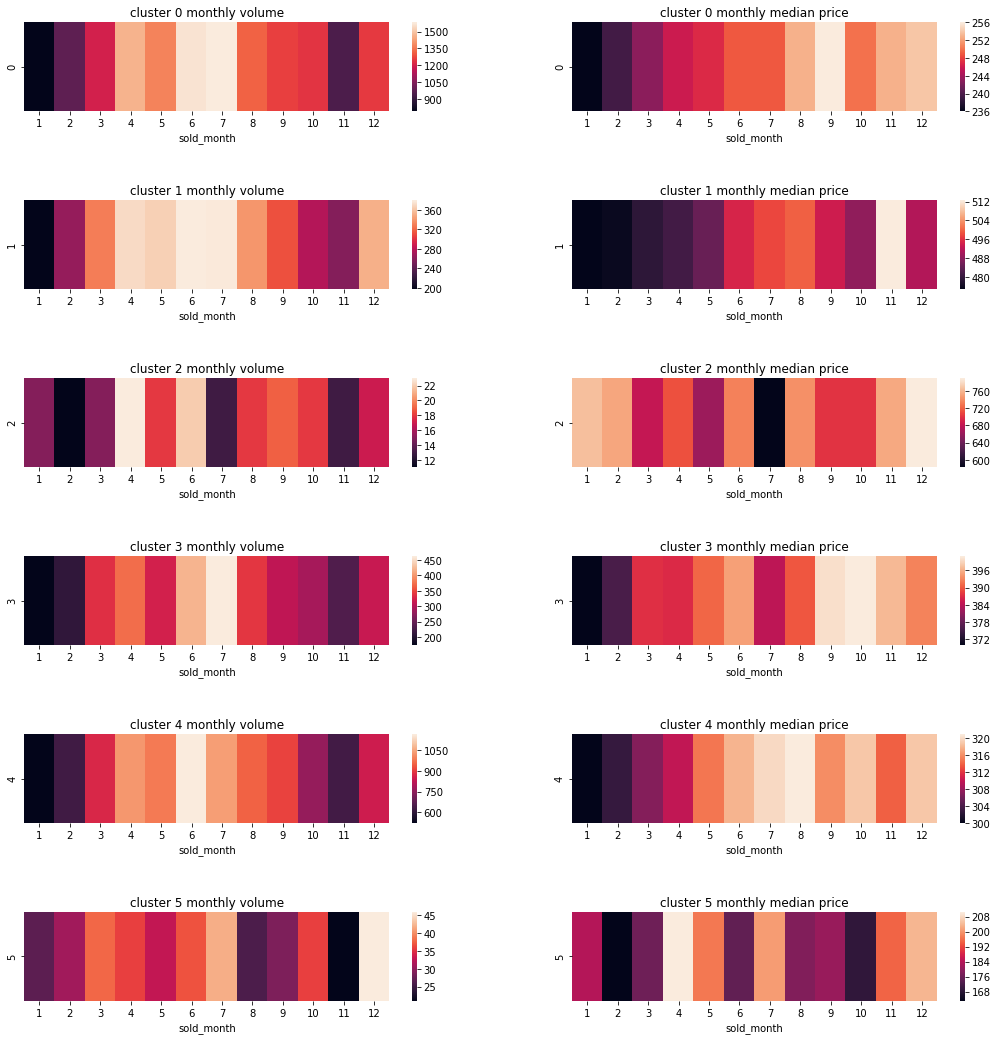

In [106]:
fig,ax = plt.subplots(1, 2, figsize=(18, 6))
sns.heatmap(monthly_volume, ax=ax[0])
ax[0].set_title('heatmap of volume in year vs month')
sns.heatmap(monthly_price, ax=ax[1])
ax[1].set_title('heatmap of median price in year vs month')

n_cluster = cluster_price.max()+1
fig,ax = plt.subplots(n_cluster, 2, figsize=(18, n_cluster*3))
plt.subplots_adjust(hspace=1)
for i in range(n_cluster):
    sns.heatmap(monthly_volume.loc[i].to_frame().T, ax=ax[i,0])
    ax[i,0].set_title('cluster {} monthly volume'.format(i))

    sns.heatmap(monthly_price.loc[i].to_frame().T, ax=ax[i,1])
    ax[i,1].set_title('cluster {} monthly median price'.format(i))
plt.show()

In [ ]:
pp = Preprocess(df_transaction, df_property)
use_features = pp.get_feature_list()
school_features = ['min_elem_distance', 'min_middle_distance', 'min_high_distance',
                   'elem_rating', 'middle_rating', 'high_rating',
                   'avg_elem_rating', 'avg_high_rating', 'avg_middle_rating']
use_features = list(set(use_features ) - set(school_features))

df_track = pp.dataset(feature='delivered', valid=True, clean=True, date=('2015-10-01', '2017-10-01'))
monthly_volume = int(df_track.shape[0] / 24)
df_track.shape

[dp] making sqft_zip_avg


In [133]:
rf = RandomForestRegressor(n_estimators=100, max_depth=14, n_jobs=-1, random_state=17)
mm = ModelManager(df_track[df_track['zip'].isin(list(zips_valid))], use_features, rf, time_series=True)
mm.run(sliding_window=monthly_volume*12, test_size=monthly_volume*4)

[dp] track/sliding/test window size: 54722, 33600, 11200
[dp] train/valid/test size: 43777, 10945, 11200
[dp] validation step is skipped


111578.42007624313

In [143]:
### prediction with clustering
result_clusters = []

for i in range(n_labels + 1):
    cluster_list = list(zips_valid[labels == i])
    print('Cluster %i: %s' % ((i + 1), ', '.join(cluster_list)))
    rf = RandomForestRegressor(n_estimators=100, max_depth=14, n_jobs=-1, random_state=17)
    df_track_filter = df_track[df_track['zip'].isin(cluster_list)]
    print('Cluster %i shape' % (i + 1), df_track_filter.shape)
    monthly_volume = int(df_track_filter.shape[0] / 24)
    mmc = ModelManager(df_track_filter, use_features, rf, time_series=True)
    rmse = mmc.run(sliding_window=monthly_volume*12, test_size=monthly_volume*4)
    print('Cluster %i rmse' % (i + 1), rmse, "\n")
    result_clusters.append(mmc.get_result_df())

[dp] track/sliding/test window size: 5127, 3072, 1024
[dp] train/valid/test size: 4101, 1026, 1024
[dp] validation step is skipped


Cluster 1: 92007, 92014, 92037, 92067, 92075, 92101, 92106, 92107, 92109
Cluster 1 shape (6151, 15)


[dp] track/sliding/test window size: 17313, 10380, 3460
[dp] train/valid/test size: 13850, 3463, 3460
[dp] validation step is skipped


Cluster 1 rmse 218152.70741611847 

Cluster 2: 91932, 91941, 91942, 92008, 92009, 92010, 92054, 92064, 92102, 92108, 92110, 92111, 92115, 92119, 92120, 92123, 92124, 92126, 92127, 92128, 92129, 92131
Cluster 2 shape (20773, 15)


[dp] track/sliding/test window size: 26107, 15660, 5220
[dp] train/valid/test size: 20885, 5222, 5220
[dp] validation step is skipped


Cluster 2 rmse 100065.82868776808 

Cluster 3: 91901, 91902, 91910, 91911, 91913, 91915, 91935, 91945, 91950, 91977, 91978, 92004, 92019, 92020, 92021, 92025, 92026, 92027, 92028, 92029, 92040, 92056, 92057, 92058, 92065, 92069, 92071, 92078, 92081, 92082, 92083, 92084, 92105, 92113, 92114, 92139, 92154, 92173
Cluster 3 shape (31327, 15)


[dp] track/sliding/test window size: 331, 192, 64
[dp] train/valid/test size: 264, 67, 64
[dp] validation step is skipped


Cluster 3 rmse 77037.0545976733 

Cluster 4: 92118
Cluster 4 shape (395, 15)


[dp] track/sliding/test window size: 6064, 3636, 1212
[dp] train/valid/test size: 4851, 1213, 1212
[dp] validation step is skipped


Cluster 4 rmse 317031.60645851673 

Cluster 5: 92011, 92024, 92103, 92104, 92116, 92117, 92122, 92130
Cluster 5 shape (7276, 15)
Cluster 5 rmse 123360.36405317478 



In [144]:
def remeasure(df_checks):
    df_merged = pd.concat(df_checks)
    print(df_merged.shape)
    return sqrt(mean_squared_error(df_merged['predict'], df_merged['sold_price']))

remeasure(result_clusters)

(10980, 17)


112608.59906668389